## Dynamic pricing model

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
from scipy import stats

In [77]:
#Load our clustering data
data=pd.read_csv("df_Amsterdam.csv")

In [3]:
#load booking data
calendar=pd.read_csv("calendar_new2.csv")

In [4]:
#rename ID column to help with joining tables
calendar=calendar.rename(columns={'listing_id':'id'})

In [5]:
#merge tables
df_merged=pd.merge(calendar, data, on='id')
df_merged.head(4)

,Unnamed: 0_x,id,date,available,price_x,minimum_nights_x,maximum_nights,dayofweek,Unnamed: 0_y,host_id,...,bed_type_Real Bed,room_type_Private room,room_type_Shared room,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,Cluster,clustering,clusterdb
0,920,306852,2020-05-09,1,200.0,3.0,21.0,5,132,1141485,...,1,0,0,0,1,0,0,0,0,-1
1,1202,306852,2020-05-10,1,200.0,3.0,21.0,6,132,1141485,...,1,0,0,0,1,0,0,0,0,-1
2,1203,306852,2020-05-11,1,200.0,3.0,21.0,0,132,1141485,...,1,0,0,0,1,0,0,0,0,-1
3,1204,306852,2020-05-12,1,200.0,3.0,21.0,1,132,1141485,...,1,0,0,0,1,0,0,0,0,-1


In [6]:
#check number of available and not available units
df_merged.available.value_counts()

0    3198528
1     400398
Name: available, dtype: int64

In [7]:
occupancy_rate=round(3198528/(3198528+400398)*100)
print("occupancy rate:",occupancy_rate,"%")

occupancy rate: 89 %


In [8]:
#delete unecessary columns
del df_merged['Cluster']
del df_merged['clusterdb']

In [9]:
df_merged.columns

Index(['Unnamed: 0_x', 'id', 'date', 'available', 'price_x',
       'minimum_nights_x', 'maximum_nights', 'dayofweek', 'Unnamed: 0_y',
       'host_id', 'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'street', 'latitude', 'longitude',
       'property_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'price_y', 'minimum_nights_y', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'calendar_updated',
       'has_availability', 'number_of_reviews', 'instant_bookable',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count', 'bed_type_Couch', 'bed_type_Futon',
       'bed_type_Pull-out Sofa', 'bed_type_Real Bed', 'room_type_Private room',
       'room_type_Shared room', 'cancellation_policy_moderate',
       'cancellation_policy_strict_14_with_grace_period',
       'cancellation_policy_super_strict_30',
       'cancellation_policy_super_strict_60', 'c

In [10]:
#choose our test case - lets select the entry with the biggest number of reviews
print(df_merged['number_of_reviews'].max())
slice=df_merged[['id','number_of_reviews']]
slice.loc[slice['number_of_reviews']==699]

699


,id,number_of_reviews
31755,694850,699
31756,694850,699
31757,694850,699
31758,694850,699
31759,694850,699
...,...,...
32115,694850,699
32116,694850,699
32117,694850,699
32118,694850,699


In [11]:
#select our test case and create new dataframe
case=df_merged.loc[df_merged['id'] == 694850]
case.shape


(365, 45)

In [12]:
case['price_x'].describe()

count    365.000000
mean      77.591781
std       13.893846
min       57.000000
25%       62.000000
50%       86.000000
75%       89.000000
max       93.000000
Name: price_x, dtype: float64

In [13]:
#see what cluster the case belongs to
case['clustering']

31755    0
31756    0
31757    0
31758    0
31759    0
        ..
32115    0
32116    0
32117    0
32118    0
32119    0
Name: clustering, Length: 365, dtype: int64

In [14]:
#remove case from original dataframe
indexNames = df_merged[ df_merged['id'] == 694850 ].index
df_merged.drop(indexNames , inplace=True)

In [15]:
#name our clusters
cluster1 = df_merged.loc[df_merged.clustering == 0] 
cluster2 = df_merged.loc[df_merged.clustering == 1] 
cluster3 = df_merged.loc[df_merged.clustering == 2] 

In [16]:
#check the mean competitor pricing per day
competitor_pricing=cluster1.groupby('date')['price_x'].mean()
competitor_pricing

date
2020-05-08    138.776378
2020-05-09    147.074196
2020-05-10    144.692011
2020-05-11    144.564366
2020-05-12    145.033571
                 ...    
2021-05-04    148.214245
2021-05-05    148.391950
2021-05-06    148.787896
2021-05-07    150.202342
2021-05-08    155.196483
Name: price_x, Length: 366, dtype: float64

In [17]:
#check competitor mean avails per day
competitor_avails=cluster1.groupby('date')['available'].sum()
competitor_avails

date
2020-05-08      2
2020-05-09    391
2020-05-10    637
2020-05-11    725
2020-05-12    780
             ... 
2021-05-04    773
2021-05-05    771
2021-05-06    772
2021-05-07    772
2021-05-08    769
Name: available, Length: 366, dtype: int64

In [18]:
#check mean price by day of the week
weekendprice=cluster1.groupby('dayofweek')['price_x'].mean()
weekendprice

dayofweek
0    146.949511
1    146.955449
2    147.058632
3    147.270424
4    149.101770
5    149.314069
6    147.128210
Name: price_x, dtype: float64

In [78]:
#from the results we see that for day 4 (Friday) price is by 1.4% higher and for day 5(Saturday) price is 1.5% higher than a weekday

In [20]:
#lets check price differences related to the month
cluster1['date'] = pd.to_datetime(cluster1['date'])

by_month=cluster1.groupby(cluster1['date'].dt.strftime('%B'))['price_x'].mean().sort_values()
by_month

C:\Users\dime\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


date
June         145.928058
July         146.026510
August       146.383675
May          146.427025
September    147.365415
February     148.127427
January      148.269995
March        148.338485
October      148.418887
April        148.871743
November     148.877413
December     149.261142
Name: price_x, dtype: float64

In [21]:
#we see that prices are higher during the months of January - April, drop in around summer and pick up again on October and spike on December.

In [22]:
#lets create a new dataframe with competitor avails and mean prices
dataframe = pd.concat([competitor_avails, competitor_pricing], axis=1, join='inner')
dataframe.reset_index(inplace = True) 
dataframe

,date,available,price_x
0,2020-05-08,2,138.776378
1,2020-05-09,391,147.074196
2,2020-05-10,637,144.692011
3,2020-05-11,725,144.564366
4,2020-05-12,780,145.033571
...,...,...,...
361,2021-05-04,773,148.214245
362,2021-05-05,771,148.391950
363,2021-05-06,772,148.787896
364,2021-05-07,772,150.202342


In [23]:
#lets separate our case prices
caseY=case[['date', 'price_x']]
caseY.head(15)

,date,price_x
31755,2020-05-09,57.0
31756,2020-05-10,57.0
31757,2020-05-11,57.0
31758,2020-05-12,57.0
31759,2020-05-13,57.0
31760,2020-05-14,57.0
31761,2020-05-15,60.0
31762,2020-05-16,61.0
31763,2020-05-17,58.0
31764,2020-05-18,57.0


In [24]:
#create a new joined table
join_tables= dataframe.merge(caseY, on='date', how='left', indicator=True)
join_tables

,date,available,price_x_x,price_x_y,_merge
0,2020-05-08,2,138.776378,NaN,left_only
1,2020-05-09,391,147.074196,57.0,both
2,2020-05-10,637,144.692011,57.0,both
3,2020-05-11,725,144.564366,57.0,both
4,2020-05-12,780,145.033571,57.0,both
...,...,...,...,...,...
361,2021-05-04,773,148.214245,86.0,both
362,2021-05-05,771,148.391950,86.0,both
363,2021-05-06,772,148.787896,89.0,both
364,2021-05-07,772,150.202342,93.0,both


In [25]:
#remove the first row and last column as they are not needed
joindf=join_tables[join_tables.date != '2020-05-08']
del joindf['_merge']
joindf

,date,available,price_x_x,price_x_y
1,2020-05-09,391,147.074196,57.0
2,2020-05-10,637,144.692011,57.0
3,2020-05-11,725,144.564366,57.0
4,2020-05-12,780,145.033571,57.0
5,2020-05-13,789,145.130143,57.0
...,...,...,...,...
361,2021-05-04,773,148.214245,86.0
362,2021-05-05,771,148.391950,86.0
363,2021-05-06,772,148.787896,89.0
364,2021-05-07,772,150.202342,93.0


In [26]:
#change our column names into something more meaningful
joindf.rename(columns={'price_x_x':'competition_price'}, inplace=True)
joindf.rename(columns={'price_x_y':'case_price'}, inplace=True)

C:\Users\dime\Anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [27]:
joindf

,date,available,competition_price,case_price
1,2020-05-09,391,147.074196,57.0
2,2020-05-10,637,144.692011,57.0
3,2020-05-11,725,144.564366,57.0
4,2020-05-12,780,145.033571,57.0
5,2020-05-13,789,145.130143,57.0
...,...,...,...,...
361,2021-05-04,773,148.214245,86.0
362,2021-05-05,771,148.391950,86.0
363,2021-05-06,772,148.787896,89.0
364,2021-05-07,772,150.202342,93.0


In [28]:
#lets examine how availability and competitor pricing affects our case price. The goal is to create an equation
#incorporates the changes of these 2 variables into a base price for our case. The base price will be the minimum charge as
#we consider that this is the lowest acceptable rate for the landlord without incurring a loss
joindf.corr()

,available,competition_price,case_price
available,1.000000,-0.531617,-0.457720
competition_price,-0.531617,1.000000,0.775211
case_price,-0.457720,0.775211,1.000000


In [29]:
#we normalize the 2 parameters so to create our equation:

norm_df=joindf[['available','competition_price']]
from sklearn import preprocessing

x = norm_df.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_norm = pd.DataFrame(x_scaled)
df_norm.columns=['available','competition_price']

In [31]:
#lets try to find the coefficients of the model by applying a linear regression model with dependent variables being the competitor availability and competition price and target price our case price
#we dont need to split into train/test samples as the target is not to predict but to use the coefficients in our formula for creating our new pricing

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split


X=df_norm[['available','competition_price']]
Y=joindf[['case_price']]

In [33]:
regr = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.25,random_state=42)

model = regr.fit(X_train,y_train)


In [34]:
print('intercept:', model.intercept_)
print('slope:', model.coef_)

intercept: [60.42452598]
slope: [[-4.62768079 65.23791914]]


In [35]:
#lets create our equation: base price +theta*available+theta1*competition_price
X['available_adj']=X['available']*-4.62768079
X['competition_adj']=X['competition_price']*65.23791914
X['base']=Y['case_price'].min()
X['trial_price']=X['base']+X['competition_adj']+X['available_adj']
X

,available,competition_price,available_adj,competition_adj,base,trial_price
0,0.000000,0.244250,-0.000000,15.934387,57.0,72.934387
1,0.407960,0.022597,-1.887910,1.474158,57.0,56.586248
2,0.553897,0.010720,-2.563259,0.699336,57.0,55.136077
3,0.645108,0.054378,-2.985353,3.547483,57.0,57.562130
4,0.660033,0.063363,-3.054423,4.133687,57.0,58.079264
...,...,...,...,...,...,...
360,0.633499,0.350328,-2.931632,22.854660,57.0,76.923028
361,0.630182,0.366863,-2.916283,23.933356,57.0,78.017073
362,0.631841,0.403704,-2.923958,26.336811,57.0,80.412854
363,0.631841,0.535313,-2.923958,34.922714,57.0,88.998757


In [37]:
X['trial_price'].describe()

count    365.000000
mean      74.074504
std       10.691240
min       53.446739
25%       67.634638
50%       74.416828
75%       80.338462
max      119.336985
Name: trial_price, dtype: float64

In [38]:
#lets see how price is adjusted basis the day of the week
#first we find what day of the week it is for every row of our calendar
weekday=cluster1.groupby('date')['dayofweek'].mean()
weekdays=weekday.to_frame()
weekdays.reset_index(inplace = True)
weekdays

,date,dayofweek
0,2020-05-08,4
1,2020-05-09,5
2,2020-05-10,6
3,2020-05-11,0
4,2020-05-12,1
...,...,...
361,2021-05-04,1
362,2021-05-05,2
363,2021-05-06,3
364,2021-05-07,4


In [44]:
#lets add to our table
merged= joindf.merge(weekdays, on='date', how='left', indicator=True)
merged

,date,available,competition_price,case_price,dayofweek,_merge
0,2020-05-09,391,147.074196,57.0,5,both
1,2020-05-10,637,144.692011,57.0,6,both
2,2020-05-11,725,144.564366,57.0,0,both
3,2020-05-12,780,145.033571,57.0,1,both
4,2020-05-13,789,145.130143,57.0,2,both
...,...,...,...,...,...,...
360,2021-05-04,773,148.214245,86.0,1,both
361,2021-05-05,771,148.391950,86.0,2,both
362,2021-05-06,772,148.787896,89.0,3,both
363,2021-05-07,772,150.202342,93.0,4,both


In [45]:
joindf["date"] = joindf["date"].apply(pd.to_datetime)


C:\Users\dime\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [46]:
weekdays.columns

Index(['date', 'dayofweek'], dtype='object')

In [47]:
merged['trial_price']=X['trial_price']

In [48]:
merged

,date,available,competition_price,case_price,dayofweek,_merge,trial_price
0,2020-05-09,391,147.074196,57.0,5,both,72.934387
1,2020-05-10,637,144.692011,57.0,6,both,56.586248
2,2020-05-11,725,144.564366,57.0,0,both,55.136077
3,2020-05-12,780,145.033571,57.0,1,both,57.562130
4,2020-05-13,789,145.130143,57.0,2,both,58.079264
...,...,...,...,...,...,...,...
360,2021-05-04,773,148.214245,86.0,1,both,76.923028
361,2021-05-05,771,148.391950,86.0,2,both,78.017073
362,2021-05-06,772,148.787896,89.0,3,both,80.412854
363,2021-05-07,772,150.202342,93.0,4,both,88.998757


In [49]:
#round up trial price and remove unecessary column "_merge"
merged.trial_price =  merged.trial_price.round()
merged.drop(['_merge'], axis = 1,inplace=True)


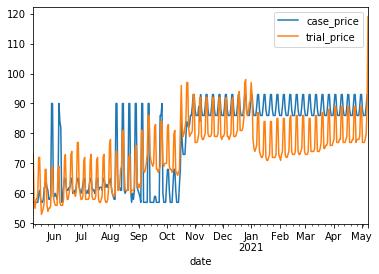

In [50]:
merged.plot(x="date", y=["case_price", "trial_price"])

In [51]:
#lets compare the annual gross revenue from case price (real cases) and our model
print(merged['case_price'].sum())
print(merged['trial_price'].sum())

28321.0
27035.0


In [52]:
#create weekday multiplier so that weekend prices are higher than weekdays
merged['weekday_mult']=merged['dayofweek'].replace([1,2,3,4,5,6],[0,0,0,0.014,0.015,0])

In [53]:
#create new adjusted price column reflecting weekend price increment
merged['adj_price']=merged['trial_price']+merged['trial_price']*merged['weekday_mult']

In [91]:
#we need to adjust also prices for months with higher demand - April,October, November and December
Oct20 = merged[(merged['date'] > '2020-10-01') & (merged['date'] <= '2020-10-31')]
Nov20 = merged[(merged['date'] > '2020-11-01') & (merged['date'] <= '2020-11-30')]
Dec20 = merged[(merged['date'] > '2020-12-01') & (merged['date'] <= '2020-12-31')]
Jan21 = merged[(merged['date'] > '2021-01-01') & (merged['date'] <= '2021-01-31')]
Feb21 = merged[(merged['date'] > '2021-02-01') & (merged['date'] <= '2021-02-28')]
Mar21 = merged[(merged['date'] > '2021-03-01') & (merged['date'] <= '2021-03-31')]
Apr21 = merged[(merged['date'] > '2021-04-01') & (merged['date'] <= '2021-04-30')]

In [92]:
#index location: October 146:175, November: 177:205 ,December 207:236, Jan 238:267, Feb 269:295, Mar 297:326,April: 328:356,

In [95]:
merged.loc[146:175,'month_adj'] = 0.014
merged.loc[177:205,'month_adj'] = 0.017
merged.loc[207:236,'month_adj'] = 0.019
merged.loc[238:267,'month_adj'] = 0.013
merged.loc[269:295,'month_adj'] = 0.012
merged.loc[297:326,'month_adj'] = 0.013
merged.loc[328:356,'month_adj'] = 0.017


merged['month_adj'] = merged['month_adj'].fillna(0) #replace NaN for the rest of the months with zero


In [96]:
merged

,date,available,competition_price,case_price,dayofweek,trial_price,weekday_mult,adj_price,month_adj,month_adj_mult,price_month_adj
0,2020-05-09,391,147.074196,57.0,5,73.0,0.016,74.168,0.0,0.0,74.0
1,2020-05-10,637,144.692011,57.0,6,57.0,0.000,57.000,0.0,0.0,57.0
2,2020-05-11,725,144.564366,57.0,0,55.0,0.000,55.000,0.0,0.0,55.0
3,2020-05-12,780,145.033571,57.0,1,58.0,0.000,58.000,0.0,0.0,58.0
4,2020-05-13,789,145.130143,57.0,2,58.0,0.000,58.000,0.0,0.0,58.0
...,...,...,...,...,...,...,...,...,...,...,...
360,2021-05-04,773,148.214245,86.0,1,77.0,0.000,77.000,0.0,0.0,77.0
361,2021-05-05,771,148.391950,86.0,2,78.0,0.000,78.000,0.0,0.0,78.0
362,2021-05-06,772,148.787896,89.0,3,80.0,0.000,80.000,0.0,0.0,80.0
363,2021-05-07,772,150.202342,93.0,4,89.0,0.014,90.246,0.0,0.0,90.0


In [97]:
merged['month_adj_mult']=merged['adj_price']*merged['month_adj']
merged['price_month_adj']=merged['adj_price']+merged['month_adj_mult']
merged['price_month_adj']=merged['price_month_adj'].round()

In [98]:
merged

,date,available,competition_price,case_price,dayofweek,trial_price,weekday_mult,adj_price,month_adj,month_adj_mult,price_month_adj
0,2020-05-09,391,147.074196,57.0,5,73.0,0.016,74.168,0.0,0.0,74.0
1,2020-05-10,637,144.692011,57.0,6,57.0,0.000,57.000,0.0,0.0,57.0
2,2020-05-11,725,144.564366,57.0,0,55.0,0.000,55.000,0.0,0.0,55.0
3,2020-05-12,780,145.033571,57.0,1,58.0,0.000,58.000,0.0,0.0,58.0
4,2020-05-13,789,145.130143,57.0,2,58.0,0.000,58.000,0.0,0.0,58.0
...,...,...,...,...,...,...,...,...,...,...,...
360,2021-05-04,773,148.214245,86.0,1,77.0,0.000,77.000,0.0,0.0,77.0
361,2021-05-05,771,148.391950,86.0,2,78.0,0.000,78.000,0.0,0.0,78.0
362,2021-05-06,772,148.787896,89.0,3,80.0,0.000,80.000,0.0,0.0,80.0
363,2021-05-07,772,150.202342,93.0,4,89.0,0.014,90.246,0.0,0.0,90.0


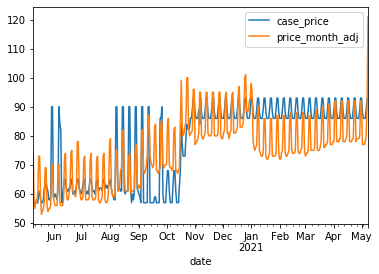

In [99]:
merged.plot(x="date", y=["case_price","price_month_adj"])

In [100]:
gross_revenue=(merged['case_price'].sum())
expected_revenue=merged['price_month_adj'].sum().round()
print(gross_revenue)
print(expected_revenue)

28321.0
27403.0


In [101]:
#lets see how much was the revenue from actual bookings
case['non_bookings']=case['price_x']*case['available']

C:\Users\dime\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [102]:
case['non_bookings'].sum()

5439.0

In [103]:
case['price_x'].sum()

28321.0

In [104]:
net_revenue=case['price_x'].sum()-case['non_bookings'].sum()
print('actual net revenue:',net_revenue)

actual net revenue: 22882.0


In [105]:
(case['price_x'].sum()-case['non_bookings'].sum())/365

62.69041095890411

In [106]:
#we create a new dataframe with only date, availability and case price
df_avail=case[['date','available','price_x']]

In [107]:
#change date form object to datetime format to help us merge tables laterone
df_avail['date'] =  pd.to_datetime(df_avail['date'], infer_datetime_format=True)


C:\Users\dime\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [108]:
#create a new dataframe containing date and our final model price
variable = merged[['date','price_month_adj']]


In [109]:
#lets merge our 2 dataframes
dataframe= df_avail.merge(variable, on='date', how='left', indicator=True)

dataframe

,date,available,price_x,price_month_adj,_merge
0,2020-05-09,1,57.0,74.0,both
1,2020-05-10,1,57.0,57.0,both
2,2020-05-11,1,57.0,55.0,both
3,2020-05-12,1,57.0,58.0,both
4,2020-05-13,1,57.0,58.0,both
...,...,...,...,...,...
360,2021-05-04,0,86.0,77.0,both
361,2021-05-05,0,86.0,78.0,both
362,2021-05-06,0,89.0,80.0,both
363,2021-05-07,0,93.0,90.0,both


In [110]:
dataframe['common']=dataframe['price_month_adj']> dataframe['price_x']
dataframe['common_bool']=dataframe['common']*1
dataframe['avail_common']=dataframe['common_bool']*dataframe['available']
dataframe['non_bookings_adj']=dataframe['price_month_adj']*dataframe['avail_common']
expected_non_bookings=dataframe['non_bookings_adj'].sum()
expected_non_bookings

2102.0

In [111]:
#lets find the expected net revenue from our model:
expected_net_revenue=merged['price_month_adj'].sum().round()-dataframe['non_bookings_adj'].sum()
print(expected_net_revenue)

25301.0


In [112]:
print("model net revenue:",expected_revenue-expected_non_bookings)
print("actual net revenue:",net_revenue)
print("expected profit/loss:",expected_net_revenue-net_revenue)

model net revenue: 25301.0
actual net revenue: 22882.0
expected profit/loss: 2419.0
